In [13]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import networkx as nx
from pathlib import Path

import torch.nn.functional as F
from torchmetrics import Accuracy
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
from sklearn.model_selection import train_test_split

In [14]:
# path = f"data\processed\balance_16k\preprocessing"
path = Path("./../../data/processed/balance_16k/preprocessing")
input_paths = [
    os.path.join(path, value) for i, value in enumerate(sorted(os.listdir(path)))
]
print(input_paths)
dataframes = [pd.read_csv(file, header=None) for file in input_paths]
int_codes, str_label = pd.factorize(dataframes[1][0])

# X = dataframes[0].iloc[:1000]
X = dataframes[0]
X = X.apply(lambda x: x- x.mean()/ x.std())
# y = int_codes[:1000]
y = int_codes

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=22
)
station_list = list(pd.unique(dataframes[1][0]))
print(station_list)

['..\\..\\data\\processed\\balance_16k\\preprocessing\\x_train.csv', '..\\..\\data\\processed\\balance_16k\\preprocessing\\y_train.csv']
['S', 'Pn', 'Lg', 'Pg', 'Sn', 'P']


In [15]:
num_segments=50
def create_graph_for_gnn(X, y, num_segments=num_segments, overlap=0.5):
    graphs = []
    segment_size = X.shape[1] // num_segments
    overlap_size = int(segment_size * overlap)

    for row in range(X.shape[0]):
        G = nx.Graph()

        for node_idx in range(num_segments):
            start = node_idx * (segment_size - overlap_size)
            end = start + segment_size
            node_features = X.iloc[row][start:end]
            G.add_node(node_idx, features=node_features)

        for i in range(num_segments):
            for j in range(i + 1, num_segments):
                G.add_edge(i, j)

        edge_index = torch.tensor(list(G.edges)).t().contiguous()
        x = torch.tensor(
            [G.nodes[node]["features"] for node in G.nodes()], dtype=torch.float
        )

        graph_data = Data(x=x, edge_index=edge_index)

        graph_data.y = torch.tensor(y[row], dtype=torch.long)

        graphs.append(graph_data)

    return graphs

graph_train_data = create_graph_for_gnn(X_train, y_train, overlap=0.5)  # You can adjust overlap as needed
graph_test_data = create_graph_for_gnn(X_test, y_test, overlap=0.5)

torch.save(graph_train_data, 'graph_train_data.pth')
torch.save(graph_test_data, 'graph_test_data.pth')

graph_train_data[0]

Data(x=[50, 144], edge_index=[2, 1225], y=4)

## Aggreration type as (aggr)

epochs = 10, training = 425 samples
| Aggregation types| Accuracy|
|-------------------|---------|
|    'mean'         | 36      |
|    'sum' or 'add' | 36      |
|   'max'           | 23      |
|   'min'           | 23      |
| 'median'          | 35      |
|   'mul'           | 24      |
|   'std'           | 36      |
|  'var'            | 36      |
| 'softmax'         | 36      |

When run on all the sample except testing accuracy is around 20% on average for all of these aggregation.

In [4]:
graph_train_data = torch.load('graph_train_data.pth')
graph_test_data = torch.load('graph_test_data.pth')

train_loader = DataLoader(graph_train_data, shuffle=True)
test_loader = DataLoader(graph_test_data, shuffle=False)

C:\Users\incognito\AppData\Local\Temp\ipykernel_15072\752587810.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_train_data = torch.load('graph_train_data.pth')
C:\

In [5]:
graph_train_data[0]
num_features = graph_train_data[0].num_features
print(num_features)

144


In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.aggr import Aggregation
from torch_geometric.utils import scatter
# Custom Pearson Aggregation Class
class PearsonAggregation(Aggregation):
    def __init__(self):
        super(PearsonAggregation, self).__init__()

    def forward(self, x, index, ptr=None, dim_size=None, dim=-1):
        # Ensure the aggregation is done over the correct dimension
        # if dim != 0:
        #     raise ValueError(f"PearsonAggregation currently only supports aggregation over dim=0, but got dim={dim}")

        # Step 1: Calculate means and standard deviations for the target and source nodes
        mean_x = scatter(x, index, dim=dim, reduce='mean', dim_size=dim_size)
        mean_x_centered = x - mean_x[index]

        std_x = scatter((x - mean_x[index]).pow(2), index, dim=dim, reduce='mean', dim_size=dim_size).sqrt()

        # Step 2: Calculate Pearson correlation using scatter
        numerator = scatter(mean_x_centered * (x - mean_x[index]), index, dim=dim, reduce='sum', dim_size=dim_size)
        denominator = scatter(std_x * std_x[index], index, dim=dim, reduce='sum', dim_size=dim_size) + 1e-8

        correlation = numerator / denominator

        # ptr is passed in some message-passing scenarios, but we are not using it in this custom aggregation
        return correlation

    def reset_parameters(self):
        pass


# Use the PearsonAggregation inside GCNConv
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_segments):
        super(GCN, self).__init__()

        # Inject the custom Pearson aggregation into the GCNConv layers
        self.conv1 = GCNConv(num_features, 128, aggr=PearsonAggregation())
        self.conv2 = GCNConv(128, 128, aggr=PearsonAggregation())
        self.conv3 = GCNConv(128, 32, aggr=PearsonAggregation())
        self.conv4 = GCNConv(32, 8, aggr=PearsonAggregation())
        self.fc = torch.nn.Linear(num_segments * 8, 6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.tanh(self.conv1(x, edge_index))
        x = F.tanh(self.conv2(x, edge_index))
        x = F.tanh(self.conv3(x, edge_index))
        x = F.tanh(self.conv4(x, edge_index))
        x = x.view(data.num_graphs, -1)
        x = self.fc(x)
        return x


In [12]:
# class GCN(torch.nn.Module):
#     def __init__(self, aggr="sum"):
#         super(
#             GCN,
#             self,
#         ).__init__()

#         self.conv1 = GCNConv(num_features, 128, aggr)
#         self.conv2 = GCNConv(128, 128, aggr)
#         self.conv3 = GCNConv(128, 32, aggr)
#         self.conv4 = GCNConv(32, 8, aggr)
#         self.fc = torch.nn.Linear(num_segments * 8, 6)

#     def forward(self, data):
#         x, edge_index = data.x, data.edge_index
#         x = F.tanh(self.conv1(x, edge_index))
#         x = F.tanh(self.conv2(x, edge_index))
#         x = F.tanh(self.conv3(x, edge_index))
#         x = F.tanh(self.conv4(x, edge_index))
#         x = x.view(data.num_graphs, -1)
#         x = self.fc(x)
#         return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(num_features, num_segments).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

for epoch in range(1, 10):
    train_loss = train()
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f},")

def evaluate(train_loader):
    model.eval()
    correct = 0
    total = 0
    acc = 0
    accuracy_metric = Accuracy(task="multiclass", num_classes=6).to(device)
    accuracy_metric.reset()
    with torch.no_grad():
        for data in train_loader:
            data = data.to(device)
            output = model(data)
            _, predicted = torch.max(output, dim=1)
            # print(f"Predicted: {predicted}, Actual: {data.y}")
            correct += (predicted == data.y).sum().item()
            total += data.y.size(0)
            acc += accuracy_metric(predicted, data.y)
    return correct / total, acc / len(train_loader)

correct, accu = evaluate(train_loader)
print(correct)
print(accu)

RuntimeError: The size of tensor a (50) must match the size of tensor b (1275) at non-singleton dimension 0

In [13]:

def evaluate(train_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    
    accuracy_metric = Accuracy(task="multiclass", num_classes=6).to(device)

    accuracy_metric.reset()
    
    with torch.no_grad():  # Disable gradient calculations for evaluation
        for data in train_loader:
            data = data.to(device)
            
            # Forward pass to get model predictions
            output = model(data)
            
            # Get the predicted class labels by selecting the maximum logit value
            _, predicted = torch.max(output, dim=1)
            
            # Compute the number of correct predictions
            correct += (predicted == data.y).sum().item()
            
            # Total number of examples processed
            total += data.y.size(0)
            
            # Update accuracy metric for the current batch
            accuracy_metric.update(predicted, data.y)
    
    # Compute overall accuracy across the entire dataset
    overall_accuracy = correct / total
    
    # Compute the accumulated accuracy from the accuracy metric
    accumulated_accuracy = accuracy_metric.compute()
    
    return overall_accuracy, accumulated_accuracy

correct, accu = evaluate(train_loader)
print(correct)
print(accu)

TypeError: PearsonAggregation.forward() got an unexpected keyword argument 'dim'

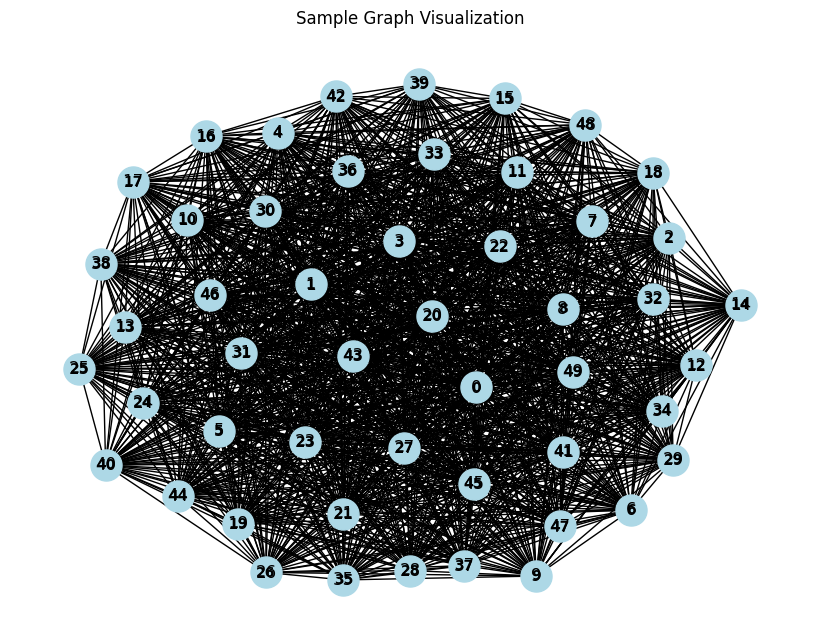

In [9]:
def plot_graph(graph_data, title="Graph Visualization"):
    """
    Plots the graph created for the GNN.

    Parameters:
    - graph_data: A PyTorch Geometric Data object representing the graph.
    - title: Title of the plot.
    """
    # Convert back to networkx for visualization
    G = nx.Graph()

    # Add nodes with features directly from the PyTorch tensor
    node_features = graph_data.x  # Stay as a tensor
    for i, features in enumerate(node_features):
        G.add_node(i, features=features.tolist())  # Convert each feature to list


    edge_index = graph_data.edge_index.t()
    for edge in edge_index:
        G.add_edge(int(edge[0]), int(edge[1]))

    pos = nx.spring_layout(G)

    plt.figure(figsize=(8, 6))

    nx.draw(G, pos, with_labels=True, node_size=500, node_color="lightblue", font_size=10, font_weight="bold")

    node_labels = {i: f"{i}" for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=node_labels)

    plt.title(title)
    plt.show()

plot_graph(graph_train_data[20], title="Sample Graph Visualization")